In [1]:
# Install required libraries for the project
# ! pip install fairlearn shap scikit-learn pandas numpy matplotlib seaborn ipywidgets

# 0. Project Overview & Data Description

This project predicts credit card default using the Default of Credit Card Clients dataset from the UCI Machine Learning Repository. We use a Logistic Regression model for prediction. However, the main focus of this project is not on how well the model performs, but on understanding its decisions using SHAP. SHAP helps us analyze and explain the model’s decision-making process for specific cases, including true positives (TP), false positives (FP), and false negatives (FN).

# 1. Data Loading and Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand its structure, check for missing values, and look at how the target variable is distributed. Knowing these details is important for effective preprocessing and interpreting the model.

In [2]:
# 1. Install and Import Libraries
import sys
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from fairlearn.datasets import fetch_credit_card
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# 2. Load Dataset
data = fetch_credit_card(as_frame=True)
X = data.data
y = data.target.astype(int)

# 3. Rename columns based on UCI official documentation for clarity
meaningful_names = [
    'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]
X.columns = meaningful_names

# 4. Check Data
# Check data shape and first few rows
print(f"Data Shape: {X.shape}")
X.head()


# Data Summary Information: Check data types and identify null values
print(X.info()) 
if X.isnull().sum().sum() == 0:
    print("Check result: No missing values found in the dataset.")

# Key Descriptive Statistics : Review mean, standard deviation, and range
display(X.describe())

# Target Variable Distribution (Default vs. Normal)
print(y.value_counts(normalize=True)) # 0: Paid on time (Normal), 1: Default payment next month (Delinquent)

Data Shape: (30000, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null 

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


y
0    0.7788
1    0.2212
Name: proportion, dtype: float64


# 2. Data Preprocessing: Scaling and Train-Test Splitting

Before training the Logistic Regression model, we need to preprocess the data. First, we apply Feature Scaling with <code>StandardScaler</code>. Logistic Regression is sensitive to the size of values. Without scaling, features with larger ranges, like Credit Limit, may be wrongly prioritized over smaller ones, like Age. Second, we divide the data into Training and Testing sets at an 80/20 ratio using Stratified Sampling. This keeps the same ratio of default cases in both sets.

In [3]:
# 5. Feature Scaling (Essential for Logistic Regression)
# Standardize features by removing the mean and scaling to unit variance (Mean=0, SD=1).

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 6. Data Splitting with Stratification
# Split data into training (80%) and testing (20%) sets. 
# Stratify=y ensures the target distribution is preserved in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Verify the split
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Verify the proportion of default (1) and normal (0) in each set.

print("--- Original Data Proportions ---")
print(y.value_counts(normalize=True))

print("\n--- Training Set Proportions ---")
print(y_train.value_counts(normalize=True))

print("\n--- Testing Set Proportions ---")
print(y_test.value_counts(normalize=True))

Training set size: (24000, 23)
Testing set size: (6000, 23)
--- Original Data Proportions ---
y
0    0.7788
1    0.2212
Name: proportion, dtype: float64

--- Training Set Proportions ---
y
0    0.778792
1    0.221208
Name: proportion, dtype: float64

--- Testing Set Proportions ---
y
0    0.778833
1    0.221167
Name: proportion, dtype: float64


# 3. Model Training and Performance Evaluation

### Logistic Regression Training & Evaluation
In this step, we train the Logistic Regression model with the training dataset.

- <code>max_iter=1000</code>: We set a higher iteration limit to make sure the model finds the best solution for this complex credit data. The default of 100 is often too low and may result in a <code>ConvergenceWarning.</code>

- Evaluation: We check the model using a Classification Report (Precision, Recall, F1-score) and a Confusion Matrix to see how accurately it predicts Normal versus Default cases.

Text(0.5, 1.0, 'Confusion Matrix (Train set)')

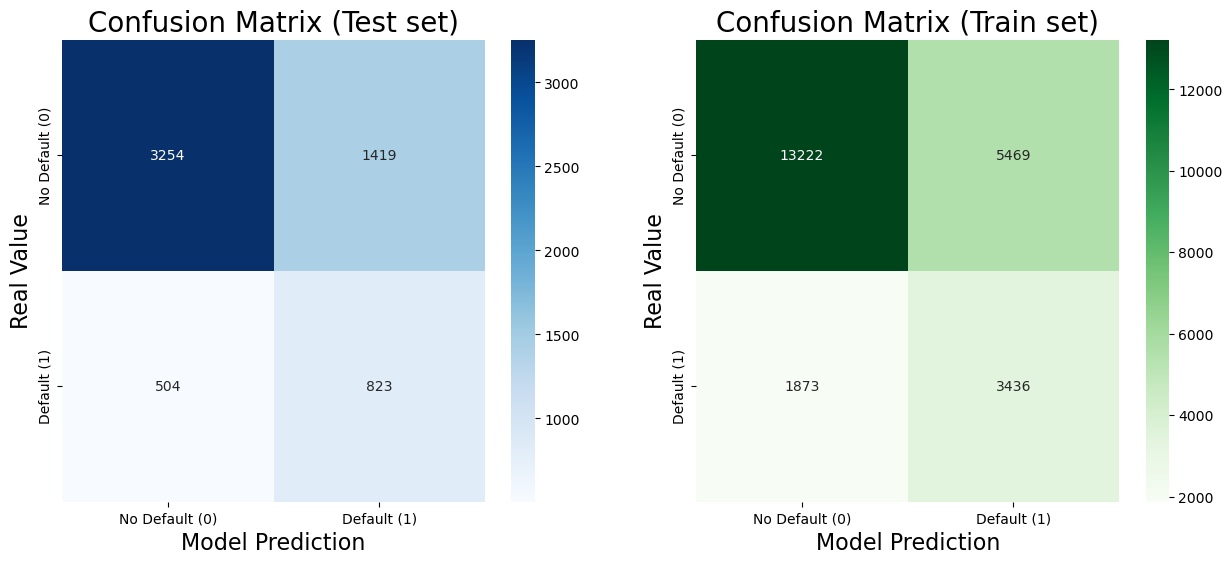

In [4]:
# 7. Train Logistic Regression Model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train) 

# 8. Model Evaluation
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# 9. Comparative Visualization of Confusion Matrices
cm_test  = confusion_matrix(y_test,  y_pred_test,  labels=[0, 1]) #confusion_matrix(row(Actual), column(Predicted))
cm_train = confusion_matrix(y_train, y_pred_train, labels=[0, 1])

labels = ["No Default (0)", "Default (1)"]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Test Set Visualization (Blue)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, ax=ax[0])
ax[0].set_xlabel("Model Prediction", size=16)
ax[0].set_ylabel("Real Value", size=16)
ax[0].set_title("Confusion Matrix (Test set)", size=20)

# Train Set Visualization (Green)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels, ax=ax[1])
ax[1].set_xlabel("Model Prediction", size=16)
ax[1].set_ylabel("Real Value", size=16)
ax[1].set_title("Confusion Matrix (Train set)", size=20)


The confusion matrix shows 504 false negative cases in the test set. In these cases, actual default customers are incorrectly predicted as non-default. These risky misclassifications highlight the importance of understanding the results. SHAP is used to examine which features lead to these wrong decisions.

# 4. Model Interpretability with SHAP

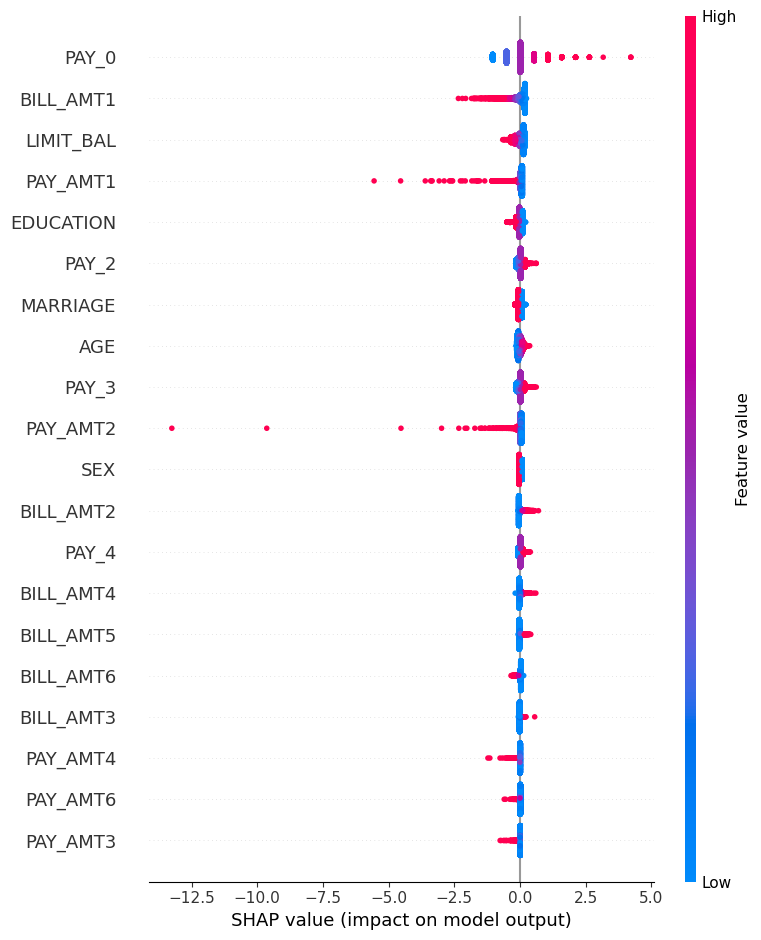

In [5]:
# 10. Model Interpretability with SHAP
shap.initjs()
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

#Summary Plot: Visualize the global importance and impact of each feature
shap.summary_plot(shap_values, X_test)

### SHAP Summary Plot Description
- This figure shows a SHAP summary plot that visualizes the most important features the model uses to predict credit card defaults. It also indicates how much each feature influences the predictions. Features at the top have a greater average impact on the model’s predictions, and each dot represents an individual sample.

- The color indicates the feature value. Red shows higher values, while blue indicates lower values. The x-axis displays the SHAP value, which shows how a feature contributes to the prediction. Values to the right of zero (positive) increase the likelihood of default, while values to the left (negative) decrease it.

### Feature-Level Interpretation with SHAP
- <code>PAY_0</code> represents the most recent repayment status, or degree of payment delay. It is the top-ranked feature and the most crucial factor in predicting credit card default. When <code>PAY_0</code> has higher values (red points), the related SHAP values cluster on the positive side.
This indicates that more severe payment delays sharply raise the likelihood of default. Conversely, lower <code>PAY_0</code> values (blue points) help reduce default risk.

- <code>PAY_AMT1</code>, which represents the payment amount made in the last month, shows red points clearly stretching toward the negative SHAP values. This suggests that larger recent repayment amounts greatly lower the chance of default. It shows that the model has effectively learned a clear and financially relevant pattern.

- <code>BILL_AMT1</code> and <code>LIMIT_BAL</code> also show relatively high importance. This suggests that billing amounts and credit limits play significant roles in the model’s predictions. In particular, higher values of <code>LIMIT_BAL</code> tend to lower default risk. This implies that customers with more available credit are less likely to default.

- Other demographic factors, like <code>education</code>, <code>marriage</code>, and <code>age</code>, have smaller effects.

- Overall, these results suggest that debt-related behavioral features have a stronger influence on default prediction than demographic characteristics.

--- Case: True Positive (Correct): Default → Default ---


<Figure size 2000x300 with 0 Axes>

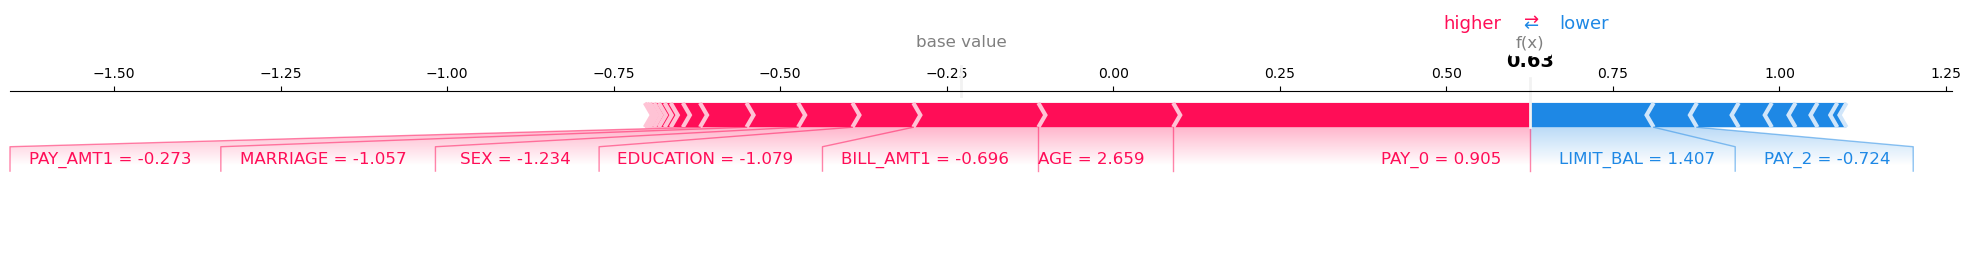

--- Case: False Positive (Error): Non-default → Default ---


<Figure size 2000x300 with 0 Axes>

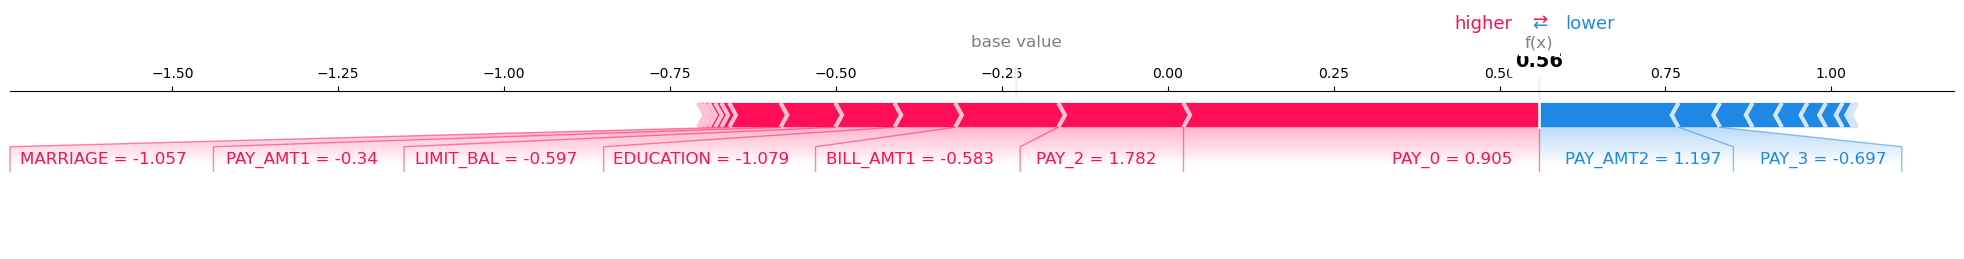

--- Case: False Negative (Error): Default → Non-default ---


<Figure size 2000x300 with 0 Axes>

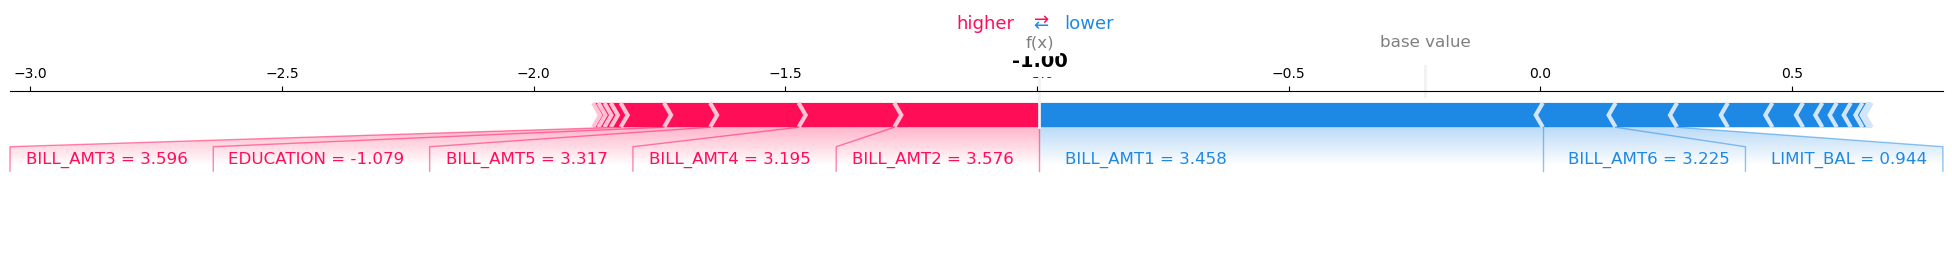

In [6]:
# 11. Create a DataFrame to examine prediction results on the test set
results = X_test.copy()
results['actual'] = y_test.values
results['predicted'] = y_pred_test

# 12. Extract indices for different prediction cases

# 1) True Positive: Actual default, correctly predicted as default
tp_idx = results[(results['actual'] == 1) & (results['predicted'] == 1)].index[0]

# 2) False Positive: Actual non-default, but predicted as default
#    (Why did the model mistakenly flag this case as risky?)
fp_idx = results[(results['actual'] == 0) & (results['predicted'] == 1)].index[0]

# 3) False Negative: Actual default, but predicted as non-default
#    (Why did the model fail to identify this risky case?)
fn_idx = results[(results['actual'] == 1) & (results['predicted'] == 0)].index[0]

indices = [tp_idx, fp_idx, fn_idx]
case_names = [
    "True Positive (Correct): Default → Default",
    "False Positive (Error): Non-default → Default",
    "False Negative (Error): Default → Non-default"
]

# 13. Visualize SHAP force plots for each selected case
# for idx, name in zip(indices, case_names):
#     print(f"--- Case: {name} ---")
#     # Convert index to positional index for SHAP values
#     loc_idx = X_test.index.get_loc(idx)
#     display(
#         shap.force_plot(
#             explainer.expected_value,
#             shap_values[loc_idx, :],
#             X_test.iloc[loc_idx, :]
#         )
#     )

# for Github
X_test_display = X_test.round(3)

for idx, name in zip(indices, case_names):
    print(f"--- Case: {name} ---")
    
    loc_idx = X_test.index.get_loc(idx)
    
    plt.figure(figsize=(20, 3)) 
    
    shap.force_plot(
        explainer.expected_value,
        shap_values[loc_idx, :],
        X_test_display.iloc[loc_idx, :], 
        matplotlib=True,        
        show=False
    )
    
    plt.tight_layout()
    plt.show()



### Case-wise Model Interpretation using SHAP Force Plots
This section analyzes three representative cases: True Positive, False Positive, and False Negative. We use SHAP force plots to see how individual features affected the model’s predictions.

**Case 1: True Positive (Correct – Default → Default)**

- Status:
  - The customer has defaulted, and the model accurately predicts this. 

- Interpretation:
  - The prediction mainly comes from **red features such as <code>PAY_0</code>**, which shows a recent payment delay and strongly indicates default.

**Case 2: False Positive (Error – Non-default → Default)**

- Status:
  - The customer has not defaulted, but the model wrongly predicts that they will.

- Interpretation:
  - Blue features like <code>PAY_AMT2</code>, <code>PAY_3</code>, and <code>AGE</code> help reduce the chances of default. 
  - However, red features such as <code>PAY_0</code> and <code>PAY_2</code>, which show past payment delays, push the prediction toward default and significantly influence the final decision.

**Case 3: False Negative (Error – Default → Non-default)**

- Status:
  - The customer has defaulted, but the model incorrectly predicts that they have not.

- Interpretation:
  - Red features such as <code>BILL_AMT2</code>,<code>BILL_AMT4</code>, <code>BILL_AMT5</code> indicate high billing amounts and increased financial burden.
  - Nevertheless, **blue features including <code>BILL_AMT1</code>, <code>BILL_AMT6</code> and <code>LIMIT_BAL</code>** shift the prediction toward non-default, leading the model to underestimate default risk.

### Why does <code>BILL_AMT1, BILL_AMT6</code> act as a blue (non-default) signal while <code>BILL_AMT2, BILL_AMT4, BILL_AMT5</code> indicate default risk in Case 3?

This behavior can be explained by the characteristics and limitations of Logistic Regression combined with SHAP-based interpretation.

- <code>BILL_AMT2</code>, <code>BILL_AMT4</code>, and <code>BILL_AMT5</code> represent billing amounts from earlier months and show consistently high values. These features contribute in the default direction, reflecting patterns in the training data where elevated past billing amounts are associated with higher default risk.

- In contrast, <code>BILL_AMT1</code> and <code>BILL_AMT6</code> support the non-default direction for this specific case, even though their standardized values are high (3.458 and 3.225). This does not mean that high billing amounts are safe. Instead, it might suggest that these features interact with the model’s learned coefficients and other related inputs. In particular, features like <code>LIMIT_BAL</code> and <code>PAY_AMT1</code> could help shift the prediction toward the non-default direction.


From a modeling perspective:

- Logistic Regression treats each feature **independently** and does **not** explicitly model **temporal patterns or trends** across multiple months.[1]
- Without designed time features, like trends or deltas, billing amounts from different months are assessed individually, based only on their identified linear contributions.
- As a result, signals from certain months, such as <code>BILL_AMT1</code> and <code>BILL_AMT6</code>, may have more influence than earlier risk indicators when paired with other features that do not lean towards default.

This limitation can lead the model to underweight persistent risk patterns across time, contributing to an underestimation of default risk in this case and resulting in a **False Negative** prediction.


[1]: Wikipedia. *Logistic regression*.

>In statistics, a logistic model (or logit model) is a statistical model that models the log-odds of an event as a linear combination of one or more independent variables. 

https://en.wikipedia.org/wiki/Logistic_regression

### Improving the Model Based on Insights from SHAP Analysis

As discussed earlier, Logistic Regression treats features in a linear and independent way. This approach limits its ability to capture repayment patterns over time and the interactions between variables. The model can recognize isolated signals like high billing amounts or large credit limits, but it struggles to analyze risk scenarios where delinquency builds up over time.

Several improvements can be made. First, we can introduce features based on trends and interactions, such as recent delinquency counts, changes in billing amounts, and payment ratios. These changes would better reflect repayment dynamics. Second, we can extend the model to interaction-aware methods like XGBoost or Random Forest. These methods may help the model capture nonlinear patterns while still allowing for SHAP-based interpretability.
